<a href="https://colab.research.google.com/github/ramiz11/Airbnb_price_prediction/blob/main/airbnb_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

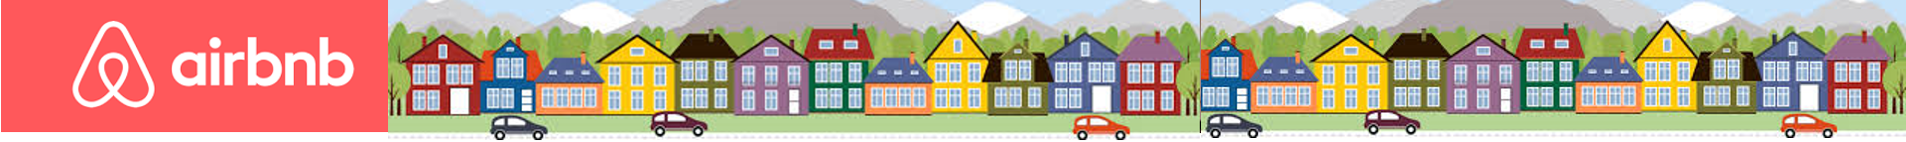

## [*Airbnb*](https://en.wikipedia.org/wiki/Airbnb) price prediction

By Rami Zaboura and Amir Ashiri


## First look

In [ ]:
# Core & Data
import pandas as pd
import numpy as np
!pip install missingno
import missingno as msno
import re
!pip install uszipcode
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
 
# System & Files
from pathlib import Path
from os.path import join
from os import path
from urllib.request import urlopen
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 400)
import pickle
# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot');
import plotly.express as px
 
# Machine Learning
from sklearn.model_selection import train_test_split as split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
!pip install afinn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from afinn import Afinn
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
afinn = Afinn(language='en')
from statistics import *

Read the data

In [ ]:
# load data
url="http://raw.githubusercontent.com/amirashiri/Airbnb-price-predict/main/"
df = pd.read_csv(urlopen(join(url, 'airbnb.csv')))
orig_df = df.copy()

In [ ]:
df.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [ ]:
df.drop('description', axis=1).head(3)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Essentials,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",3,1.0,Real Bed,strict,True,NYC,2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c034-459c-bc82-6522c957627c.jpg?aki_policy=small,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",7,1.0,Real Bed,strict,True,NYC,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4b65-452a-b48a-bfecb3b58a66.jpg?aki_policy=small,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air conditioning"",Kitchen,Breakfast,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",5,1.0,Real Bed,moderate,True,NYC,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9e3a-4fa9-aa54-bbd5ea26538d.jpg?aki_policy=small,10027,1.0,3.0


## EDA

Initial transformations: int-like and boolean-like columns

In [ ]:
# column types
df.beds = df.beds.astype('Int64')
df.bedrooms = df.bedrooms.astype('Int64')
df.cleaning_fee = df.cleaning_fee.astype(int)
df.host_has_profile_pic = df.host_has_profile_pic.map({'t': 1, 'f': 0})
df.host_identity_verified = df.host_identity_verified.map({'t': 1, 'f': 0})
df.instant_bookable = df.instant_bookable.map({'t': 1, 'f': 0})
df.zipcode = df.zipcode.fillna('').apply(lambda x: re.sub(r'\D.', '', x))
df.zipcode = df.zipcode.apply(lambda x: 0 if len(str(x)) < 5 else int(str(x)[:5]))
df.zipcode = df.zipcode.astype('float').astype('Int64')
df.host_response_rate = df.host_response_rate.fillna('').apply(lambda x: np.nan if x == '' else int(x.replace('%','')))

Display column dtypes after conversion

In [ ]:
df.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                int64
city                       object
description                object
first_review               object
host_has_profile_pic      float64
host_identity_verified    float64
host_response_rate        float64
host_since                 object
instant_bookable            int64
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                     Int64
bedrooms                    Int64
beds                        Int64
dtype: object

Initial transformations: date-related columns

In [ ]:
df['host_since'] = pd.to_datetime(df.host_since)
df['first_review'] = pd.to_datetime(df.first_review)
df['last_review'] = pd.to_datetime(df.last_review)

Check activity over time

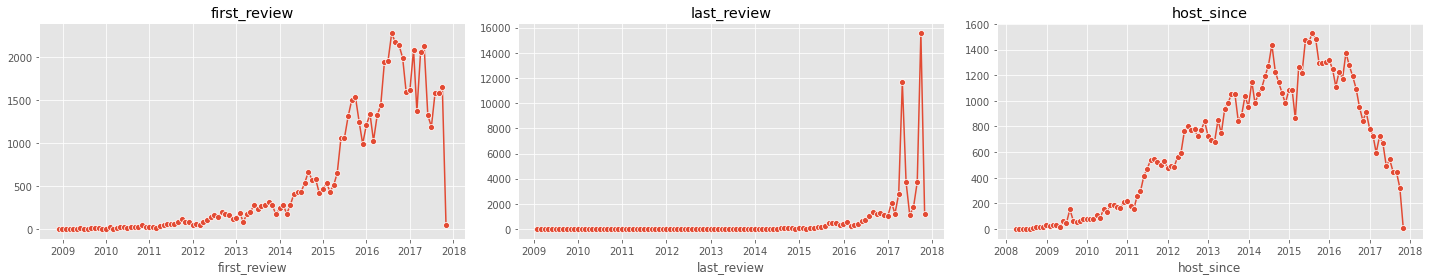

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
for i, col in enumerate(['first_review', 'last_review', 'host_since']):
    time_df = df[[col]]
    time_df.index = df[col]
    time_df = time_df.groupby(pd.Grouper(freq='M')).count()
    sns.lineplot(data=time_df, marker='o', ax=ax[i], legend=False)
    ax[i].set_title(col)
fig.tight_layout()

Add price in dollars, as a reference

In [ ]:
df['price'] = df.log_price.apply(lambda x: np.exp(x))

Take a look at our target variable, log_price. As a reference, create a dollar price, too

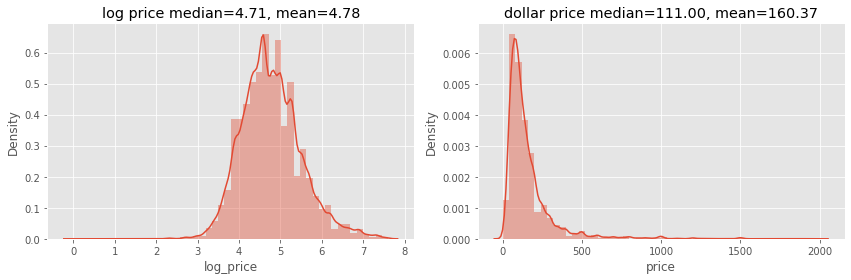

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(df.log_price, ax=ax[0])
sns.distplot(df.price, ax=ax[1])
ax[0].set_title(f'log price median={df.log_price.median():.2f}, mean={df.log_price.mean():.2f}');
ax[1].set_title(f'dollar price median={df.price.median():.2f}, mean={df.price.mean():.2f}');
fig.tight_layout()

Check unique values

In [ ]:
df.nunique().sort_values()

host_identity_verified        2
host_has_profile_pic          2
cleaning_fee                  2
instant_bookable              2
room_type                     3
bed_type                      5
cancellation_policy           5
city                          6
bedrooms                     11
accommodates                 16
bathrooms                    17
beds                         18
property_type                35
review_scores_rating         54
host_response_rate           80
number_of_reviews           371
neighbourhood               619
zipcode                     648
price                       767
log_price                   767
last_review                1371
first_review               2554
host_since                 3087
thumbnail_url             65883
amenities                 67122
name                      73359
description               73479
latitude                  74111
longitude                 74111
id                        74111
dtype: int64

### Price distribution by geographical areas

In [ ]:
map_source = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}'
fig={}
for i, city in enumerate(['NYC', 'LA', 'SF', 'DC', 'Chicago', 'Boston']):
    sample = 2500 if city == 'Boston' else 1000
    df_temp = df[df.city == city].sample(sample, random_state=0)
    df_temp['log_price'] = np.round(df_temp.log_price, 2)
    fig[i] = px.scatter_mapbox(df_temp, lat="latitude", lon="longitude", hover_data=['log_price'], color='log_price', zoom=10)
    fig[i].update_layout(title='Prices in ' + city, geo_scope='usa', width=600, height=400, mapbox_style="white-bg", mapbox_layers=[{"below": 'traces', "sourcetype": "raster", "source": [map_source]}])
    fig[i].show()

### Which numeric & boolean features are correlated to the price?


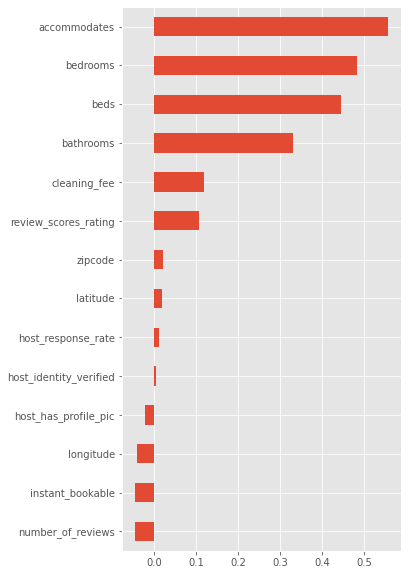

In [ ]:
cols = list(df.select_dtypes(exclude=object).columns)[1:]
list(df.select_dtypes(exclude=object).columns)
samp_corr = df[cols].sample(5000).corr().fillna(0)
samp_corr = samp_corr[(~samp_corr.index.isin(['log_price', 'price'])) & (abs(samp_corr.log_price) > 0)][['log_price']].sort_values('log_price')
samp_corr.plot.barh(figsize=(5,10), fontsize=10, legend=False);

Interestingly, some factors have negative corrleation. Both positive and negative are important (if significant)

### How are the categorical features related to price?

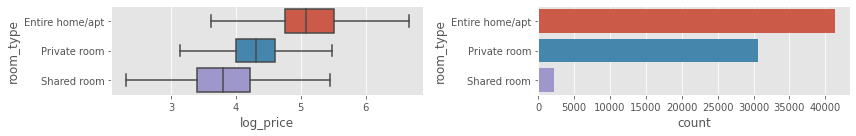

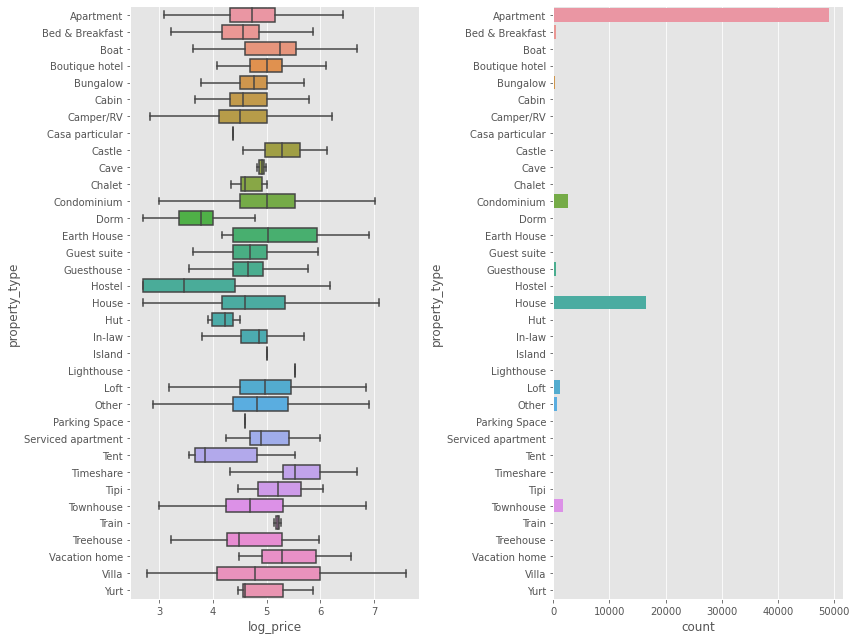

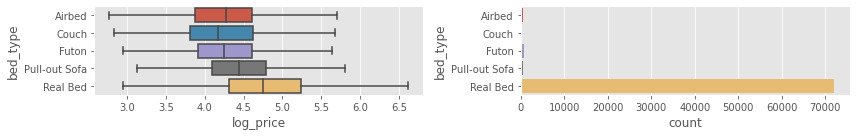

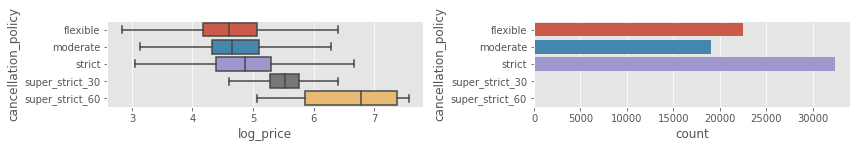

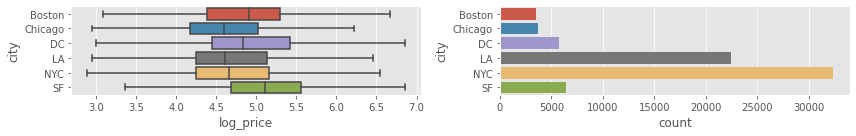

In [ ]:
box_cols = ['room_type', 'property_type', 'bed_type',  'cancellation_policy', 'city']
for col in box_cols:
    box_df = df[['log_price']]
    box_df[col] = df[col].fillna(0).apply(lambda x: str(x))
    box_order = pd.Series(df[col].fillna(0).unique()).sort_values().apply(lambda x: str(x))
    width = max(2, int(np.ceil(box_df[col].nunique()*0.25)))
    fig, ax = plt.subplots(1,2, figsize=(12, width))
    sns.boxplot(x='log_price', y=col, showfliers=False, data=box_df, order=box_order, ax=ax[0])
    sns.countplot(y=col, data=box_df, order=box_order, ax=ax[1])
    fig.tight_layout()

* There are 6 major cities in our dataset - New York and Los Angelos with most listings
* San Fransisco is the most expensive city to live in, while chicago is the cheapest city to live in 
* Entire homes costs more, shared rooms are the cheapest
* Properties with strict rules tend to cost more

### How is price distributed by by both city and room type?

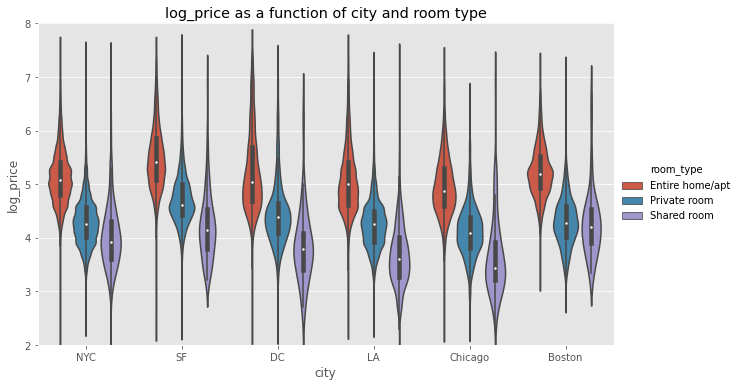

In [ ]:
sns.set_color_codes()
sns.catplot(data=df, x='city', y='log_price',hue='room_type',kind='violin', aspect=1.7)
plt.ylim([2,8])
plt.title("log_price as a function of city and room type");

### Corrlations between features<br>
(including price)

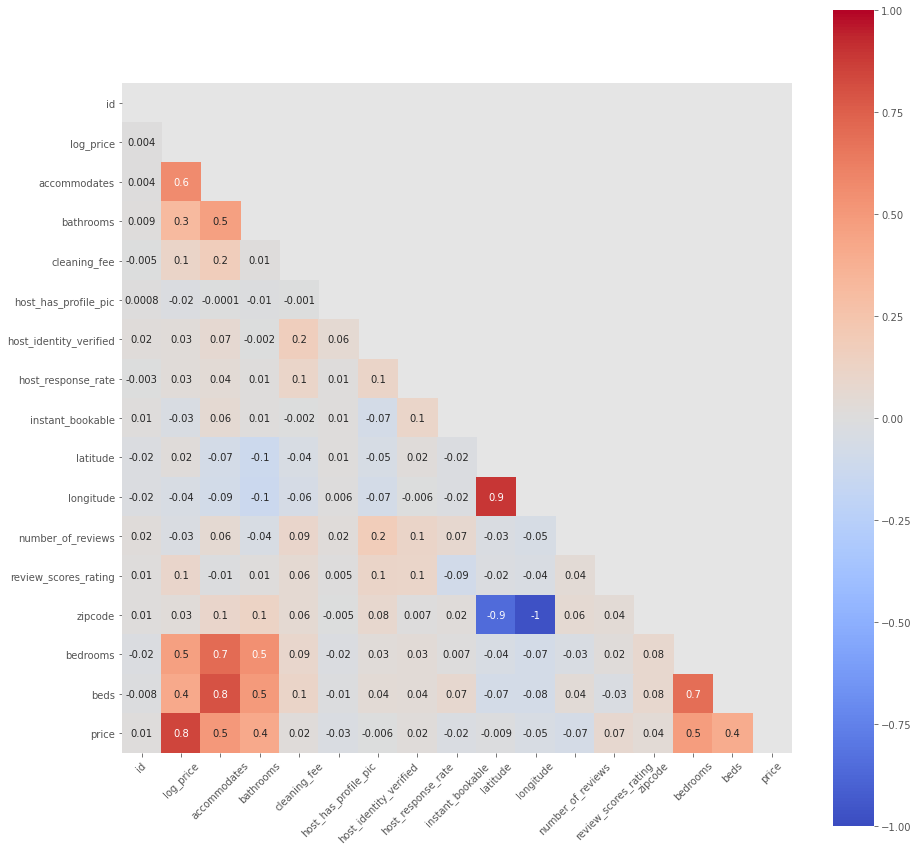

In [ ]:
df_samp = df.sample(5000)
fig, ax = plt.subplots(1, 1, figsize=(15,15))
sns.heatmap(df_samp.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True, mask=np.triu(df_samp.corr()))
ax.tick_params(axis='x', labelrotation=45)

### Property descriptions

Let's inspect the description of the properties with the highest prices:

In [ ]:
df.sort_values(by='log_price',ascending=False).name.head()

42672                       Huge Loft with Private Entrance
19210    Beverly Hills Estate Pool, Tennis & Jetliner Views
60071                   Cozy apartment in Van Ness on metro
55453                                        Royal Manor!!!
72609              Spacious Three-bedroom Trinidad Rowhouse
Name: name, dtype: object

And now, those with the lowest prices:

In [ ]:
df.sort_values(by='log_price',ascending=True).name.head()

11632                                        Esteem's Place
3898         Upper West Side Studio Steps from Central Park
25239                     Center of The Washington DC-BUNKS
19806                      Private bed/bath in lux building
23917    Shared funny cozy room one block from Times Square
Name: name, dtype: object

## Imputation & Cleanup

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      74111 non-null  int64         
 1   log_price               74111 non-null  float64       
 2   property_type           74111 non-null  object        
 3   room_type               74111 non-null  object        
 4   amenities               74111 non-null  object        
 5   accommodates            74111 non-null  int64         
 6   bathrooms               73911 non-null  float64       
 7   bed_type                74111 non-null  object        
 8   cancellation_policy     74111 non-null  object        
 9   cleaning_fee            74111 non-null  int64         
 10  city                    74111 non-null  object        
 11  description             74111 non-null  object        
 12  first_review            58247 non-null  dateti

Remove columns that won't benefit our prediction model

In [ ]:
df.drop(['thumbnail_url', 'id'],axis=1,inplace=True)
df.shape

(74111, 28)

Missing values correlation map 

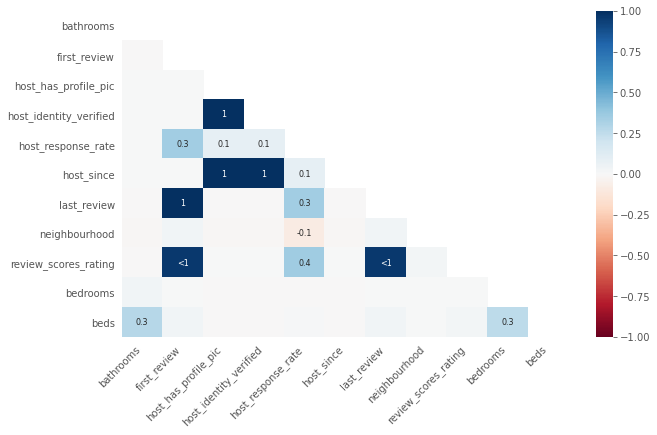

In [ ]:
msno.heatmap(df, figsize=(10, 6), fontsize=10);

Text(0.5, 1.0, 'null percentage in each column')

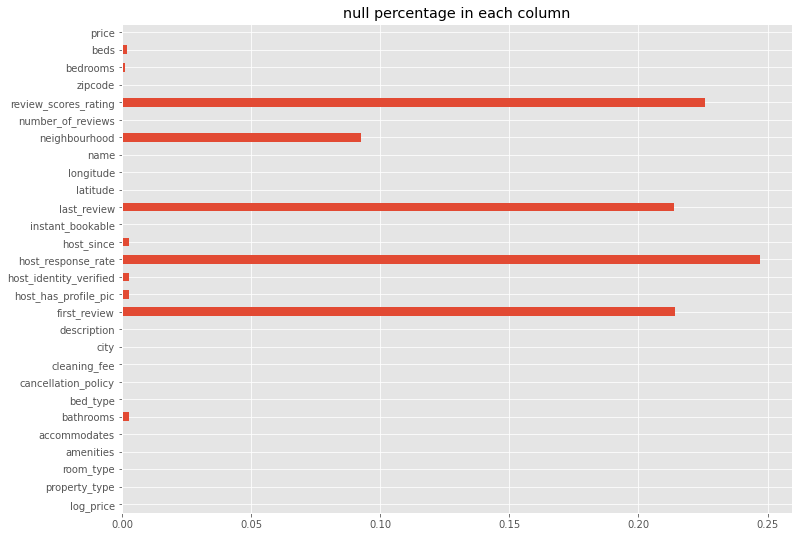

In [ ]:
#display which columns have null values:
plt.figure(figsize=(12,9))
((df.isnull().sum())/(df.shape[0])).plot.barh()
plt.title("null percentage in each column")

Fill each column according to its values & dtype

* the numerical columns `beds`,`bedrooms`,`review_scores_rating` `bathrooms`,`host_response_rate` missing values- will be filled either with the median of the column or with 0
* categorical columns: `neighbourhood`,`last_review`,`first_review`,`host_since`,`host_has_profile_pic`,`host_identity_verified`will be filled with a string that specifies their absence

In [ ]:
#fill missing values in categorical columns - soon to be numerical
df.fillna({'neighbourhood':"Unknown"}, inplace=True)
df.fillna({'last_review':"Unknown"}, inplace=True)
df.fillna({'first_review':"Unknown"}, inplace=True)
df.fillna({'host_since':"Unknown"}, inplace=True)

In [ ]:
#fill missing values in numerical columns
df.fillna({'beds':df.beds.median()},inplace=True)
df.fillna({'bedrooms':df.bedrooms.median()},inplace=True)
df.fillna({'host_response_rate':df.host_response_rate.median()}, inplace=True)
df.fillna({'host_identity_verified':0}, inplace=True)
df.fillna({'host_has_profile_pic':0}, inplace=True)

in-order for us to know how to fill missing values of feature: `bathrooms`, we will use the help of the `room_type` feature which is logically related to it,  if the room_type for example is a shared room - then it would make since that the missing value of bathroom is 0 , however if there are room types of Entire home with missing values for bathrooms - then it will make since to fill the missing value with the median of the column

In [ ]:
b=df[['bathrooms','room_type']]
b[b.bathrooms.isnull()].groupby('room_type').agg({'bathrooms':"size"}) #null values in all room_types

,bathrooms
room_type,
Entire home/apt,62
Private room,127
Shared room,11


In [ ]:
def fillna_bathrooms(x):

    """ if the missing value of bathrooms belongs to a room_type of "Entire home/apt" or "Private room" then we will fill the missing value with the median of the column
        else if the missing value of bathroom belongs to a room_type of "shared room" then we will fill the missing value with 0 
        we will pass the function a pd.Series of the indexes of the null values of bathrooms and see to what kind of room they belong  """
    med=df.bathrooms.median()
    for point in x:
        if df.room_type.iloc[point]=='Entire home/apt' or df.room_type.iloc[point]=='Private room':
            df.bathrooms.iloc[point]=med
        else:
            df.bathrooms.iloc[point]=0


fillna_bathrooms(pd.Series(df[df.bathrooms.isnull()].bathrooms.index))

*review_scores_rating*<br>we have to inspect rows with these columns as missing values and their link to number of reviews to understand if to fill them with zeros or the median of the column
* if there were 0 number of reviews- then it doesn't make sense to fill the missing value by the median of the scores - since there are no reviews to begin with.
* however if there are number of reviews > 0 - then we will fill the missing value by the median of the scores

In [ ]:
null_scores=df[df.review_scores_rating.isna()][['number_of_reviews','review_scores_rating']].sort_values(by='number_of_reviews')
#perepate a list of indexes of the displayed dataframe - to show the change in null values to different values later
null_scores_index=[]
null_scores_index.extend(list(null_scores.head().index))
null_scores_index.extend(list(null_scores.tail().index))
null_scores

,number_of_reviews,review_scores_rating
3,0,NaN
48697,0,NaN
48698,0,NaN
48701,0,NaN
48712,0,NaN
...,...,...
20598,43,NaN
22024,47,NaN
48459,63,NaN
22285,101,NaN


In [ ]:
def fillna_review_scores(x):
    med=df.review_scores_rating.median()
    for point in x:
        if df.number_of_reviews.iloc[point]==0:
            df.review_scores_rating.iloc[point]=0
        else:
            df.review_scores_rating.iloc[point]=med


fillna_review_scores(pd.Series(df[df.review_scores_rating.isnull()].review_scores_rating.index))

In [ ]:
df.iloc[null_scores_index][['number_of_reviews','review_scores_rating']].sort_values(by='number_of_reviews')

,number_of_reviews,review_scores_rating
3,0,0.0
48697,0,0.0
48698,0,0.0
48701,0,0.0
48712,0,0.0
20598,43,96.0
22024,47,96.0
48459,63,96.0
22285,101,96.0
16162,131,96.0


Let's make sure that there are no more missing values in our dataset:

In [ ]:
df.isnull().sum().sum()

0

## Outliers

Look at the numeric columns (of dtype int64 or float64)

In [ ]:
df.select_dtypes(np.number).head()

,log_price,accommodates,bathrooms,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,price
0,5.010635,3,1.0,1,1.0,1.0,100.0,0,40.696524,-73.991617,2,100.0,11201,1,1,150.0
1,5.129899,7,1.0,1,1.0,0.0,100.0,1,40.766115,-73.989040,6,93.0,10019,3,3,169.0
2,4.976734,5,1.0,1,1.0,1.0,100.0,1,40.808110,-73.943756,10,92.0,10027,1,3,145.0
3,6.620073,4,1.0,1,1.0,1.0,100.0,0,37.772004,-122.431619,0,0.0,94117,2,2,750.0
4,4.744932,2,1.0,1,1.0,1.0,100.0,1,38.925627,-77.034596,4,40.0,20009,0,1,115.0


### price\ log_price

In [ ]:
df.price.describe()

count    74111.000000
mean       160.370849
std        168.580415
min          1.000000
25%         75.000000
50%        111.000000
75%        185.000000
max       1999.000000
Name: price, dtype: float64

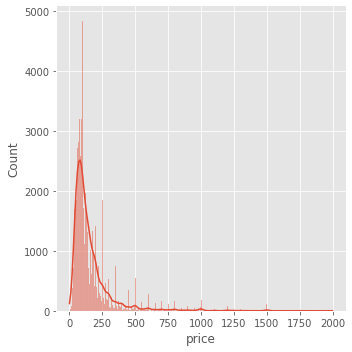

In [ ]:
sns.displot(data=df,x='price',kde=True)

In [ ]:
price_counts=df.price.value_counts().reset_index()
price_counts.rename({"index":"price","price":"count"},inplace=True,axis=1)
price_counts.sort_values(by='price')

,price,count
701,1.0,1
648,5.0,1
232,10.0,30
670,11.0,1
413,12.0,5
...,...,...
730,1975.0,1
590,1980.0,1
614,1990.0,1
377,1995.0,6


* we decided to drop the listing with price==1, we interpret the price as the price for one night - so 1$ per night doesn't make sense, although there are also really high prices - but we can think of cases where that could be true, especially because there are apartments that can fill up a large number of guests and we don't consider it "bad data"

In [ ]:
df=df[~((df.price==1) | (df.log_price==0))]
df.shape

(74110, 28)

### accomodates 
this column is logically related to the apartment type - in terms of outliers, any large apartment will have large values in this feature, especially an apartment of type "Entire home",so we will look at suspected outliers carefully and drop only bad data which doesn't make sense

(0.0, 1000.0)

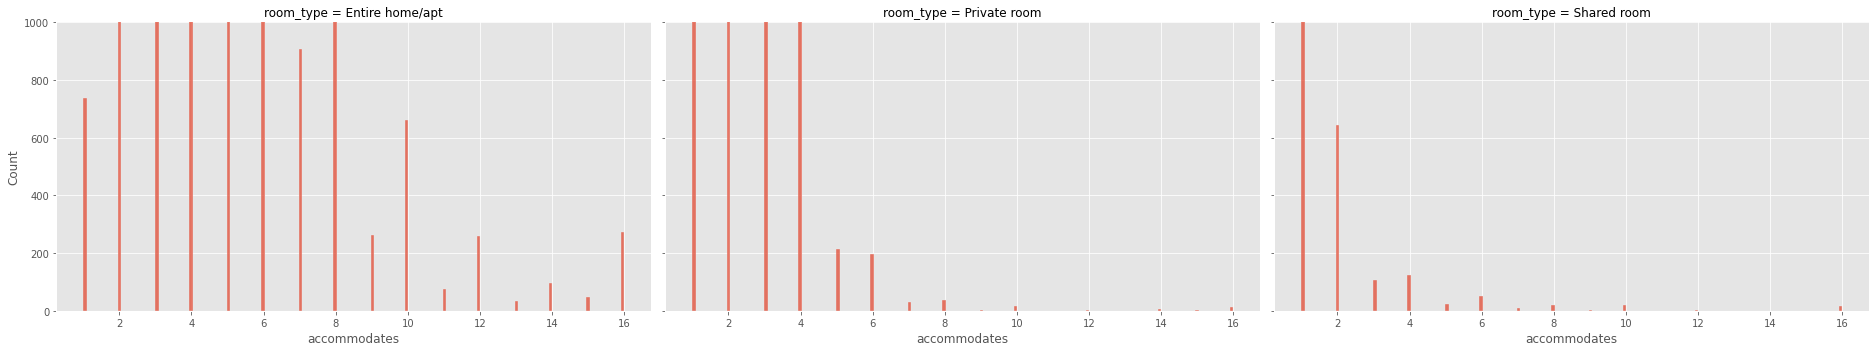

In [ ]:
sns.displot(data=df,x='accommodates',col='room_type',kind='hist',aspect=1.75)
plt.ylim([0,1000])

from the airbnb site:
- Private room: Guests have their own private room for sleeping. Other areas could be shared.
- Shared room: Guests sleep in a bedroom or a common area that could be shared with others.

so from these definitions, it doesn't make much sense to have a large number of accommodates in these types of room , and we can see from the distribution plot , that values larger than 10 in these types of rooms are indeed rare, let's drop them:

In [ ]:
a=df[(df.room_type=="Shared room")|(df.room_type=="Private room")]
b=df[df.room_type=="Entire home/apt"]
large_accomodates_index_list=list(a[a.accommodates>10].index)
df=df[~df.index.isin(large_accomodates_index_list)]
df.shape

(74060, 28)

### Bathrooms

* also related to room types



Text(0.5, 1.0, 'cummalative percentage distribution of bathrooms')

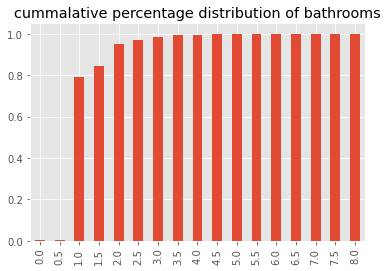

In [ ]:
df.bathrooms.value_counts(normalize=True).sort_index().cumsum().plot.bar()
plt.title("cummalative percentage distribution of bathrooms")

* 0-4.5 bathrooms consist of almost 100% of the data
* any value larger than 4.5 in room types "Shared_room" and "Private room" will be considered an outlier
* any value equal to 0 in room type "Entire home" will be accounted as an outlier

In [ ]:
large_bathrooms_list=list(a[a.bathrooms>4.5].index)
df=df[~df.index.isin(large_bathrooms_list)]
small_bathrooms_list=list(b[b.bathrooms==0].index)
df=df[~df.index.isin(small_bathrooms_list)]
df.shape

(73977, 28)

### beds,bedrooms

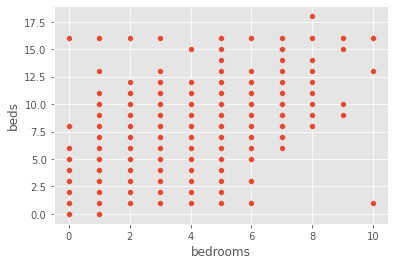

In [ ]:
sns.scatterplot(data=df,x='bedrooms',y='beds')

* samples that have bedrooms>beds don't make sense
* samples with 0 bedrooms and multiple beds make sene sense only in a room type"shared room " which by definition specifies that :  Guests sleep in a bedroom **or a common area** that could be shared with others - so we remove samples with 0 bedrooms and multiple beds only from other kinds of rooms
* we won't account 0 bedrooms and 0 beds as outliers since we have proprety types such as "train" 


In [ ]:
df=df[df.bedrooms<=df.beds]
df=df[~ ((df.bedrooms==0) & (df.beds>0) & (df.room_type!="Shared room"))]
df.shape

(66379, 28)

### number_of_reviews, review_scores_rating

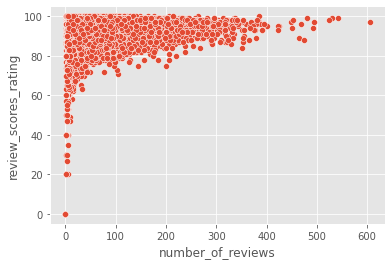

In [ ]:
sns.scatterplot(data=df,x='number_of_reviews',y='review_scores_rating')

* no problem with the samples, small or big number of reviews doesn't make any difference in our interpretation of the score, large number of reviews is not bad data...

### Latitude and longtitude

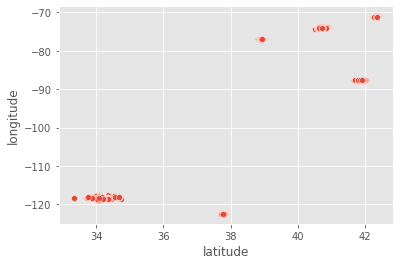

In [ ]:
sns.scatterplot(data=df,x='latitude',y='longitude')

In [ ]:
# latitude unique value count
pd.Series(df.latitude.value_counts().values).unique()

array([1])

In [ ]:
# longitude unique value count
pd.Series(df.longitude.value_counts().values).unique()

array([1])

* both latitude and longtitude have an even distribution of all values - each value appears once - so there is no pattern to judge outliers by

zipcode

In [ ]:
# a  US zipcode should contain 5 digits, any other zipcode will be dropped
df['zipcode']=df.zipcode.apply(lambda x:x if len(str(x))>4 else -1)
bad_zipcodes=df[df.zipcode==-1].index
df.drop(bad_zipcodes,axis=0,inplace=True)

## Category Encoding

### Handle the Amenities<br>
Our one hot enconding version

In [ ]:
df.amenities = df.amenities.apply(lambda x: re.sub(r'{|}|"', "", x).strip())
amenities = df.amenities.str.split(',', expand=True).stack().drop_duplicates().sort_values()
amenities = list(amenities.loc[amenities.str.len() > 0])

count = 0
for amenity in amenities:
    count += 1
    print(f'Adding amenity {count} of {len(amenities)}: {amenity}')
    df[amenity] = df.apply(lambda row: 1 if amenity in row.amenities.split(',') else 0, axis=1)
df.drop('amenities', axis=1, inplace=True)

Adding amenity 1 of 130:  smooth pathway to front door
Adding amenity 2 of 130: 24-hour check-in
Adding amenity 3 of 130: Accessible-height bed
Adding amenity 4 of 130: Accessible-height toilet
Adding amenity 5 of 130: Air conditioning
Adding amenity 6 of 130: Air purifier
Adding amenity 7 of 130: BBQ grill
Adding amenity 8 of 130: Baby bath
Adding amenity 9 of 130: Baby monitor
Adding amenity 10 of 130: Babysitter recommendations
Adding amenity 11 of 130: Bath towel
Adding amenity 12 of 130: Bathtub
Adding amenity 13 of 130: Bathtub with shower chair
Adding amenity 14 of 130: Beach essentials
Adding amenity 15 of 130: Beachfront
Adding amenity 16 of 130: Bed linens
Adding amenity 17 of 130: Body soap
Adding amenity 18 of 130: Breakfast
Adding amenity 19 of 130: Buzzer/wireless intercom
Adding amenity 20 of 130: Cable TV
Adding amenity 21 of 130: Carbon monoxide detector
Adding amenity 22 of 130: Cat(s)
Adding amenity 23 of 130: Changing table
Adding amenity 24 of 130: Children’s books

Amenities new columns

In [ ]:
amenities_start_col = df.columns.get_loc('price')+1
df.iloc[:,amenities_start_col:].head(3)

,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bath towel,Bathtub,Bathtub with shower chair,Beach essentials,Beachfront,Bed linens,Body soap,Breakfast,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Cooking basics,Crib,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Doorman Entry,Dryer,EV charger,Elevator,Elevator in building,Essentials,...,Pets live on this property,Pocket wifi,Pool,Private bathroom,Private entrance,Private living room,Refrigerator,Roll-in shower with chair,Room-darkening shades,Safety card,Self Check-In,Shampoo,Single level home,Ski in/Ski out,Smart lock,Smartlock,Smoke detector,Smoking allowed,Stair gates,Step-free access,Stove,Suitable for events,TV,Table corner guards,Toilet paper,Washer,Washer / Dryer,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower & toilet,Wide clearance to shower and toilet,Wide doorway,Wide entryway,Wide hallway clearance,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


### Categorical columns

In [ ]:
df.drop(['description','name','first_review','host_since','last_review'], axis=1).select_dtypes('object').head(3)

,property_type,room_type,bed_type,cancellation_policy,city,neighbourhood
0,Apartment,Entire home/apt,Real Bed,strict,NYC,Brooklyn Heights
1,Apartment,Entire home/apt,Real Bed,strict,NYC,Hell's Kitchen
2,Apartment,Entire home/apt,Real Bed,moderate,NYC,Harlem


In [ ]:
df = pd.get_dummies(data=df,columns=['room_type','bed_type','cancellation_policy','city'])
# We'll deal with property_type later in this notebook... 

### Coding neighbourhood column
* this column has a large number of levels, so we decided to code it using a different method than 'one hot encoding'

note: this does have its disadvantages, but we decided to go for it since it will produce a much more "workable" dataframe 


In [ ]:
df["neighbourhood"] = df["neighbourhood"].astype('category')
df['neighbourhood_code'] = df.neighbourhood.cat.codes

# change the value of "Unknown" category (which is origionally null) to -1, so it won't mean nothing for our model
neighborhood_df = df[['neighbourhood','neighbourhood_code']]
Unknown_value=int(pd.Series(neighborhood_df[neighborhood_df.neighbourhood=="Unknown"].neighbourhood_code.values).unique()[0])
df['neighbourhood_code'] = df.neighbourhood_code.apply(lambda x: -1 if x == Unknown_value else x)
# display the change done in the coding of neighbourhood for "Unknown" values (origionally null) then drop the neighbourhod column 
print(df[['neighbourhood','neighbourhood_code']])
df.drop('neighbourhood', axis=1, inplace=True)

          neighbourhood  neighbourhood_code
0      Brooklyn Heights                  71
1        Hell's Kitchen                 235
2                Harlem                 231
3          Lower Haight                 306
5            Noe Valley                 368
...                 ...                 ...
74105           Unknown                  -1
74106      Williamsburg                 573
74107     Hermosa Beach                 238
74108      Williamsburg                 573
74110        Long Beach                 300

[62413 rows x 2 columns]


## Feature engineering

### Date features<br>
Create year columns, and the difference between the first and last reviews

In [ ]:
#since we converted the null values to "Unknown" string - we need to return them back to null so we can access pd.dt and then create our conversions
df['host_since']=df.host_since.apply(lambda x:x if x!="Unknown" else np.nan) 
df['first_review']=df.first_review.apply(lambda x:x if x!="Unknown" else np.nan) 
df['last_review']=df.last_review.apply(lambda x:x if x!="Unknown" else np.nan) 
df['host_since_year'] = df.host_since.dt.year
df['first_review_year'] = df.first_review.dt.year
df['last_review_year'] = df.last_review.dt.year
df['review_span'] = (df.last_review - df.first_review).dt.days
df.drop(['host_since', 'first_review','last_review'],axis=1,inplace=True)
#now clean the null values:
df.fillna({'host_since_year':0}, inplace=True)
df.fillna({'first_review_year':0}, inplace=True)
df.fillna({'last_review_year':0}, inplace=True)
df.fillna({'review_span':0}, inplace=True)

### Amenities & groups

In [ ]:
# Add number of amenities feature
amenities_first_col=df.columns.get_loc('price')+1
amenities_last_col=df.columns.get_loc('room_type_Entire home/apt')
df['amenities_num'] = df.iloc[:,amenities_start_col:amenities_last_col].sum(axis=1)

In [ ]:
groups = {}
groups['kitchen'] = ["Kitchen","Breakfast","Cooking basics","BBQ grill","Oven","Stove","Coffee maker","Microwave","Refrigerator","Dishwasher","Hot water kettle","Dishes and silverware"]
groups['basic_kitchen'] = ["Kitchen","Cooking basics","Oven","Stove","Microwave","Refrigerator","Dishwasher"]
groups['access'] = ["Free parking on premises","Wide clearance to bed"," smooth pathway to front door","Flat smooth pathway to front door","Ground floor access","Wheelchair accessible","Wide clearance to shower & toilet","Wide clearance to shower and toilet","Wide hallway clearance","Wide doorway","Accessible-height toilet","Grab-rails for shower and toilet","Fixed grab bars for shower & toilet","Step-free access","Well-lit path to entrance","Path to entrance lit at night","Disabled parking spot","Accessible-height bed","Elevator","Elevator in building","Wide entryway","Bathtub with shower chair"]
groups['basic_access'] = ["Wheelchair accessible","Accessible-height toilet","Disabled parking spot"]
groups['laundry'] = ["Washer","Washer / Dryer","Dryer"]
groups['basic_laundry'] = ["Washer","Washer / Dryer"]
groups['comm'] = ["Ethernet connection","Cable TV","Internet","EV charger","TV","Wireless Internet","Pocket wifi","Keypad","Game console","Laptop friendly workspace"]
groups['basic_comm'] = ["Ethernet connection","Cable TV","Internet","TV","Wireless Internet","Pocket wifi"]
groups['sea'] = ["Lake access","Waterfront","Beachfront","Pool"]
groups['basic_sea'] = ["Lake access","Waterfront","Beachfront"]
groups['extra'] = ["Private living room","Gym","Free parking on street","Hot tub","Bathtub","Beach essentials","Indoor fireplace","Ski in/Ski out"]
groups['basic_extra'] = ["Private living room","Gym"]
groups['house'] = ["Patio or balcony","Garden or backyard","Single level home","Private entrance"]
groups['basic_house'] = ["Patio or balcony","Garden or backyard"]
groups['supplies'] = ["Air purifier","Handheld shower head","Extra pillows and blankets","Firm matress","Bed linens","First aid kit","Buzzer/wireless intercom","Firm mattress","Iron","Changing table","Hangers","Roll-in shower with chair","Outlet covers","Essentials","Bath towel","Shampoo","Body soap","Hand soap","Hand or paper towel","Toilet paper","Room-darkening shades","Hair dryer" ]
groups['basic_supplies'] = []
groups['kids'] = ["Babysitter recommendations","Family/kid friendly","Children’s books and toys","Children’s dinnerware","Baby monitor","Baby bath","High chair","Crib","Table corner guards","Pack ’n Play/travel crib","Stair gates","Fireplace guards"]
groups['basic_kids'] = []
groups['security'] = ["Window guards","Doorman","Carbon monoxide detector","Smoke detector","Fire extinguisher","Lock on bedroom door","Smart lock","Smartlock","Lockbox","Safety card"]
groups['basic_security'] = ["Window guards","Doorman","Smart lock","Smartlock"]
groups['pets'] = ["Cat(s)","Pets allowed","Other pet(s)","Dog(s)","Pets live on this property"]
groups['basic_pets'] = []
groups['entry'] = ["Doorman Entry","Self Check-In","24-hour check-in","Host greets you","Luggage dropoff allowed"]
groups['basic_entry'] = []

amenity_groups = ['kitchen', 'access', 'laundry', 'comm', 'sea', 'extra', 'house', 'supplies', 'kids', 'security', 'pets', 'entry']
for col in amenity_groups:
    print('Creating amenity group:', col) 
    df[col] = df[groups[col]].sum(axis=1)
    if len(groups['basic_'+col]) > 0:
        df['basic_'+col] = df[groups['basic_'+col]].apply(lambda row: bool(row.sum())*1, axis=1)

Creating amenity group: kitchen
Creating amenity group: access
Creating amenity group: laundry
Creating amenity group: comm
Creating amenity group: sea
Creating amenity group: extra
Creating amenity group: house
Creating amenity group: supplies
Creating amenity group: kids
Creating amenity group: security
Creating amenity group: pets
Creating amenity group: entry


Rearrange the dataframe, to sequentially position all one-hot encoded new features

In [ ]:
base = range(df.columns.get_loc('price')+1)
one_hot_1 = range(df.columns.get_loc('price')+1, df.columns.get_loc('neighbourhood_code'))
categ = range(df.columns.get_loc('neighbourhood_code'), df.columns.get_loc('amenities_num')+1)
one_hot_2 = range(df.columns.get_loc('amenities_num')+1, len(df.columns))
df = df.iloc[:, np.r_[base, categ, one_hot_1, one_hot_2]]

Remove new features with less than 1% populated values 

In [ ]:
print('shape before removal:', df.shape)
one_hot = df.iloc[:, df.columns.get_loc('amenities_num')+1:].sum()
remove_cols = list(one_hot[one_hot < 0.01 * len(one_hot)].index)
print('removing', remove_cols)
df.drop(remove_cols, axis=1, inplace=True)
print('shape after removal:', df.shape)

shape before removal: (62413, 193)
removing ['Bath towel', 'Body soap', 'Hand or paper towel', 'Hand soap', 'Toilet paper', 'Wide clearance to shower and toilet']
shape after removal: (62413, 187)


Correlations between amenity groups (and price)

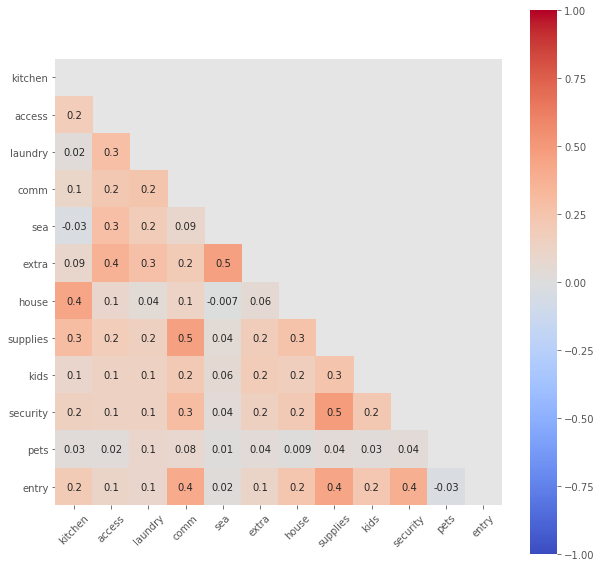

In [ ]:
df_samp = df[amenity_groups].sample(5000)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.heatmap(df_samp.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True, mask=np.triu(df_samp.corr()))
ax.tick_params(axis='x', labelrotation=45)

### Text descriptions





In [ ]:
df.name.head()

0              Beautiful brownstone 1-bedroom
1    Superb 3BR Apt Located Near Times Square
2                            The Garden Oasis
3          Beautiful Flat in the Heart of SF!
5                 Comfort Suite San Francisco
Name: name, dtype: object

In [ ]:
df.description.head()

0                                                                                                                                                                                                Beautiful, sunlit brownstone 1-bedroom in the loveliest neighborhood in Brooklyn. Blocks from the promenade and Brooklyn Bridge Park, with their stunning views of Manhattan, and from the great shopping and food.
1    Enjoy travelling during your stay in Manhattan. My place is centrally located near Times Square and Central Park with easy access to main subways as well as walking distance to many popular restaurants and bus tours. My place is close to the subway, Totto Ramen, Hell's Kitchen, Ippudo Westside, Empanada Mama, Intrepid Sea, Air & Space Museum. My place has three true bedrooms and one bathroom. ...
2    The Oasis comes complete with a full backyard with outdoor furniture to make the most of this summer vacation!!  The unit has high ceilings, a completed renovation throughout, beautiful

In [ ]:
# Add description length feature
df['desc_len'] = df.description.apply(lambda x: len(x))
# Add name length feature
df['name_len'] = df.name.apply(lambda x: len(x))

the columns are very related- they describe the same apartment in similar ways, one shorter\more abstract than the other, let's create a new column combining both (will be dropped later) and extract groups of keywords from it

In [ ]:
df['text'] = df.name.apply(lambda x:x+" ") + df.description
#Add text length feature 
df['text_len'] = df.text.apply(lambda x:len(x))
df.text.head()

0                                                                                                                                                                 Beautiful brownstone 1-bedroom Beautiful, sunlit brownstone 1-bedroom in the loveliest neighborhood in Brooklyn. Blocks from the promenade and Brooklyn Bridge Park, with their stunning views of Manhattan, and from the great shopping and food.
1    Superb 3BR Apt Located Near Times Square Enjoy travelling during your stay in Manhattan. My place is centrally located near Times Square and Central Park with easy access to main subways as well as walking distance to many popular restaurants and bus tours. My place is close to the subway, Totto Ramen, Hell's Kitchen, Ippudo Westside, Empanada Mama, Intrepid Sea, Air & Space Museum. My place h...
2    The Garden Oasis The Oasis comes complete with a full backyard with outdoor furniture to make the most of this summer vacation!!  The unit has high ceilings, a completed renovation thro

Show the most common words in the `text` column

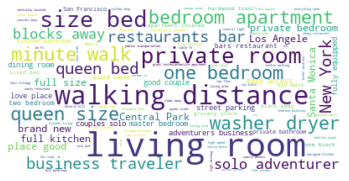

In [ ]:
# generqate a large text of all the reviews 
large_text=" ".join(txt for txt in df.text)
# create a list of words that are not informative that we don't want to include the wordcloud
# Default English stopwords list:
stop_words=stopwords.words('english')
wordcloud = WordCloud(stopwords=stop_words,max_font_size=40, max_words=100, background_color="white").generate(large_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
text_location=["close",'walking distance','walk','distance','minute walk','restaurant','bar'
                ,"bar's restaurant",'blocks away','Central Park','Central','Center','subway','train','park'
                ,'Los Angeles','San Fransisco','New York','NYC','North','West','buses','bus','beach','Downtown','Hollywood'
                    ,'north','west','grocery store','mall','shopping','fitness center','Venice beach','site seeing'
                    ,'bike trail','Wholefoods','Museum','bakeries','bakery','coffe shop','Cafe','pizza','attraction','Tourist','gas station','venice' ]

text_location_transportation=['subway','train','bus','bike trail','gas station']

text_location_food_and_drinks=['restaurant','bar','grocery store','store','Wholefoods','bakeries','bakery','coffe shop','Cafe','pizza']

text_location_attractions=['shopping','park','Central Park','Hollywood','beach','Downtown','mall',
                           'Museum','fitness centers','fitness center','Venice beach','site seeing','attraction','Tourist','venice' ]
text_location_distance=["close","walking distance",'walk','distance','minute walk','blocks away','block away','block','blocks','Central','Center','north','west']

text_design_and_traits=['full kitchen','private room','kitchen',"modern","building",'brand new','apartment','living room',
                    'two bedroom','hardwood','home','house','easy access','fully equipped','hardwoord floor','large','big',
                    'private','bed','bedroom','steet parking','parking','queen','size bed','queen size','furnished','renovated'
                    'queen size bed','washer','dryer','dining room','master bedroom','new','high','high ceiling','roof','basement','complete','bar',
                    'mini fridge','fridge','microwave', 'coffee maker', 'coffee fixings','Cottage','balcony','TV','towels','bedding','view','fireplace']

text_general=['beautiful','cozy','comfortable','wonderful','amazing','great','spacious','space','perfect','comfortably','fancy','peaceful','clean','sunny','luxury','luxurious'
                     'charming',"lovely","good","couple","couples","solo",'adventurer','adventurers','business','good couple','safe','quiet','warm','cute','resonable']


In [ ]:
text_list = [text_location,text_location_transportation,text_location_food_and_drinks,text_location_attractions,text_location_distance,text_design_and_traits,text_general]
text_list_names = ['text_location','text_location_transportation','text_location_food_and_drinks','text_location_attractions',
                        'text_location_distance','text_design_and_traits','text_general']

#### Create new features based on the groups we just made 

In [ ]:
def code_text(name, some_list):
    d = pd.DataFrame()
    for word in some_list:
        d[word] = df.text.str.contains(word, case=False, regex=True)
    df[name] = d.sum(axis=1).apply(lambda x:1 if x>0 else 0)
    print('created', name, 'with', df[name].sum(), 'True values')

In [ ]:
for index, name in enumerate(text_list_names):
    code_text(name, text_list[index])

created text_location with 59473 True values
created text_location_transportation with 34309 True values
created text_location_food_and_drinks with 34315 True values
created text_location_attractions with 44282 True values
created text_location_distance with 52911 True values
created text_design_and_traits with 61108 True values
created text_general with 58103 True values


show new coded columns and drop the textual columns

In [ ]:
df.drop(['description','name','text'], axis=1, inplace=True)
text_start = df.columns.get_loc('text_location')
df.iloc[:,text_start:].head()

,text_location,text_location_transportation,text_location_food_and_drinks,text_location_attractions,text_location_distance,text_design_and_traits,text_general
0,1,0,0,1,1,1,1
1,1,1,1,1,1,1,1
2,1,0,0,0,1,1,1
3,1,1,1,0,1,1,1
5,1,1,1,0,1,1,1


Checking if the new columns have enought true values, we can see that the 
 minimum percentage of true values is larger than 50%

In [ ]:
text_df = df.iloc[:,text_start:]
(text_df.sum(axis=0).values)/len(df)

array([0.95289443, 0.5497092 , 0.54980533, 0.70949962, 0.84775608,
       0.97909089, 0.93094387])

Property size: create a combined size feature based on: accomodates, beds, bedrooms


In [ ]:
df["size"]=df.bedrooms *1 +df.accommodates*0.5 +df.beds*0.25 
df["size"].head()

0    2.75
1    7.25
2    4.25
3    4.50
5    2.25
Name: size, dtype: float64

* we will do that by multiplying each value by an assigned weight, the weight differs based on which column has a bigger impact on size from our understanding, Weights: bedrooms --> 1, ,accomodates --> 0.5 , beds -->0.25 , 
* example for the weight distribution: 1 bedroom - 2 guests (accommodates) - 4 beds. the bedroom weight is twice the guests and 4 times the weight of beds , because it takes less by 2,by 4 respectively to achieve the same goal of occupying a certain space

Property Type Group: group key property types

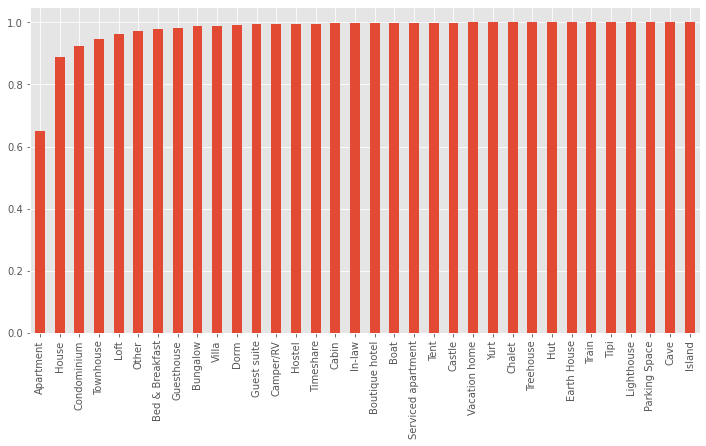

In [ ]:
plt.figure(figsize=(12,6))
df.property_type.value_counts(normalize=True).cumsum().sort_values(ascending=True).plot.bar()

* main properties: Apartment, House, Condominium, Townhouse, Loft

In [ ]:
def property_one_hot_encoding(name):
    df["property_"+name]=df.property_type.apply(lambda x : 1 if x==name else 0)

main_properties=['Apartment','House','Condominium','Townhouse','Loft']
for name in main_properties:
    property_one_hot_encoding(name)
df.drop('property_type', axis=1, inplace=True)

#### Zip codes: apply a linear model to create a zipcode-price_predictor


In [ ]:
# create new features based on zipcodes
search = SearchEngine()
# zipcode = search.by_zipcode()
df['zipcode_population_density']=df.zipcode.apply(lambda x:(search.by_zipcode(x)).population_density)
df['zipcode_median_household_income']=df.zipcode.apply(lambda x:(search.by_zipcode(x)).median_household_income)
df['zipcode_housing_units']=df.zipcode.apply(lambda x:(search.by_zipcode(x)).housing_units)
df=df.fillna({"zipcode_population_density":0,"zipcode_median_household_income":0,"zipcode_housing_units":0})

In [ ]:
#build a linear model that predicts price based on the newly created columns
X_zipcode=df[['zipcode_population_density','zipcode_median_household_income','zipcode_housing_units']]
# remove null values
y_zipcode=df.log_price
X_zipcode_train, X_zipcode_test, y_zipcode_train, y_zipcode_test = split(X_zipcode, y_zipcode, test_size=0.3, random_state=314159)
lin_model= linear_model.LinearRegression().fit(X_zipcode_train, y_zipcode_train)
y_zipcode_train_pred = lin_model.predict(X_zipcode_train)
# inspect the mean mistake in prediction
print(f'the model makes an average mistake by a proportion of: {str(np.exp(mse(y_true= y_zipcode_train,y_pred=y_zipcode_train_pred)))[2:4]}%')

the model makes an average mistake by a proportion of: 60%


* the model is pretty bad in predicting, but we did expect that since we didn't adjust it and applied the usual life cycle of a machine learning model, it will only be used as a feature 

In [ ]:
# validate the model
y_zipcode_test_pred = lin_model.predict(X_zipcode_test)
# inspect the mean mistake in prediction
print(f'the model makes an average mistake by a proportion of: {str(np.exp(mse(y_true= y_zipcode_test ,y_pred=y_zipcode_test_pred)))[2:4]}%')

the model makes an average mistake by a proportion of: 61%


* The model is valid, so we'll try to use it in our final model

#### Geographical price estimation features

* motivation for the following new features: instead of representing zipcodes and neighborhoods with numerical codes which don't say much, we'll help the model by specifying more meaningful values per each such territory.
We'll use the popular combination of propery_type = appartment, and room type = Entire Home, as a proxy for zipcodes and neighborhood price level.
We'll also create a count feature, describing how many properties exist in a zipcode or neighborhood.<br>
We'll use the following code in our final model.


In [ ]:
zip_price = df[(df['room_type_Entire home/apt'] == 1) & (df['property_Apartment'] == 1)].groupby('zipcode')\
    .agg(zip_price=('log_price', 'median'), zip_count=('zipcode', 'count'))
 
neighbor_price = df[(df['room_type_Entire home/apt'] == 1) & (df['property_Apartment'] == 1)].groupby('neighbourhood_code')\
    .agg(neighbor_price=('log_price', 'median'), neighbor_count=('zipcode', 'count'))



Now, let's create a new feature of predicted price based on, literaly, 'nearest neighbors, using the latitude and longitude columns

In [ ]:
X_sim = df[['latitude','longitude']]
y_sim = df.log_price
X_sim_train, X_sim_test, y_sim_train, y_sim_test = split(X_sim, y_sim, test_size=0.3, random_state=214514)
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_sim_train, y_sim_train)
y_sim_train_pred= knn_model.predict(X_sim_train)
# inspect the mean mistake in prediction
print(f'The model error proportion is {np.exp(mse(y_true= y_sim_train,y_pred=y_sim_train_pred)**0.5) :.2%}')

The model error proportion is 178.25%


In [ ]:
# validate knn model
y_sim_test_pred = knn_model.predict(X_sim_test)
# inspect the mean mistake in prediction
print(f'The model error proportion is {np.exp(mse(y_true= y_sim_test,y_pred=y_sim_test_pred)**0.5) :.2%}')

The model error proportion is 190.61%


* Actual predictions are inaccurate, but it's valid model which can serve as a proxy for the price level in the property exact location, so we'll try to use in in our final model

Bath to Bed Ratio: number of bathrooms per bedroom

In [ ]:
df['bath_ratio'] = df.apply(lambda row: 0 if row.bedrooms == 0 else row.bathrooms / row.bedrooms, axis=1)

## Load the updated dataframe 

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1D7jE9TEffN9mID14e6urcnCT_T6iqLgH', dest_path='./updated_df.pkl')
df= pd.read_pickle('updated_df.pkl')

## Prediction model



Create our Full Model class, including the help-models

In [ ]:
class FullModel:
    def __init__(self):
        self.lin_model = linear_model.LinearRegression()
        self.knn_model = KNeighborsRegressor(n_neighbors=10)
        self.rf_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
#       self.rf_model = XGBRegressor()
        self.zip_stats = ['zipcode_population_density','zipcode_median_household_income','zipcode_housing_units']


    def fit(self, X, y):
        # Geography-based simple prediction
        popular = (X['room_type_Entire home/apt'] == 1) & (X['property_Apartment'] == 1)
        self.zip_price = y.groupby(X[popular].zipcode).agg(zip_price=('median'), zip_count=('count'))
        self.neighbor_price = y.groupby(X[popular].neighbourhood_code).agg(neighbor_price=('median'), neighbor_count=('count'))
        X = X.merge(self.zip_price, on='zipcode', how='left').merge(self.neighbor_price, on='neighbourhood_code', how='left')
        X['zip_price'] = X.zip_price.fillna(4.7)
        X['neighbor_price'] = X.neighbor_price.fillna(4.7)
        X = X.fillna(0)

        # Linear model based on general zipcode attributes
        self.lin_model.fit(X[self.zip_stats],y)
        X['zipcode_price_predictor'] = self.lin_model.predict(X[self.zip_stats])

        # KNN model based on coordinates
        self.knn_model.fit(X[['latitude','longitude']], y)
        X['nearby_price'] = self.knn_model.predict(X[['latitude','longitude']])

        # Random forest model, with all features
        self.rf_model.fit(X, y)
        return self
    
    def predict(self, X):
        X = X.merge(self.zip_price, on='zipcode', how='left').merge(self.neighbor_price, on='neighbourhood_code', how='left')
        X['zip_price'] = X.zip_price.fillna(4.7)
        X['neighbor_price'] = X.neighbor_price.fillna(4.7)
        X = X.fillna(0)
        X['zipcode_price_predictor'] = self.lin_model.predict(X[self.zip_stats])
        X['nearby_price'] = self.knn_model.predict(X[['latitude','longitude']])
        return self.rf_model.predict(X)                      

Create a first random forest model

In [ ]:
df_sample = df.sample(10000 ,random_state=0)
X, y = df_sample.drop(columns=['log_price', 'price']), df_sample.log_price
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=0)
fm=FullModel()
fm =fm.fit(X_train, y_train)
y_train_pred = fm.predict(X_train)
print(f'train RMSE is {np.exp(mse(y_train, y_train_pred)**0.5) :.2f}')
y_test_pred = fm.predict(X_test)
print(f'test RMSE is {np.exp(mse(y_test, y_test_pred)**0.5) :.2f}')

train RMSE is 1.18
test RMSE is 1.51


Compare results to a simple model

In [ ]:
#create a model that predicts price based on room_type 
class BenchmarkModel():
    def __init__(self):
        self.basic_model = linear_model.LinearRegression()
    def fit(self, X, y):
        self.basic_model.fit(X[['room_type_Entire home/apt','room_type_Private room','room_type_Shared room']],y)
   
    def predict(self, X):
        return self.basic_model.predict(X[['room_type_Entire home/apt','room_type_Private room','room_type_Shared room']])

In [ ]:
compare_model=BenchmarkModel()
compare_model.fit(X_train,y_train)
y_compare_train_pred=compare_model.predict(X_train)
y_compare_test_pred=compare_model.predict(X_test)
print(f'train RMSE is {np.exp(mse(y_train, y_compare_train_pred)**0.5) :.2f}')
print(f'test RMSE is {np.exp(mse(y_test, y_compare_test_pred)**0.5) :.2f}')

train RMSE is 1.75
test RMSE is 1.76


plotting our base model and the simple compare model predicted test values vs actual test values

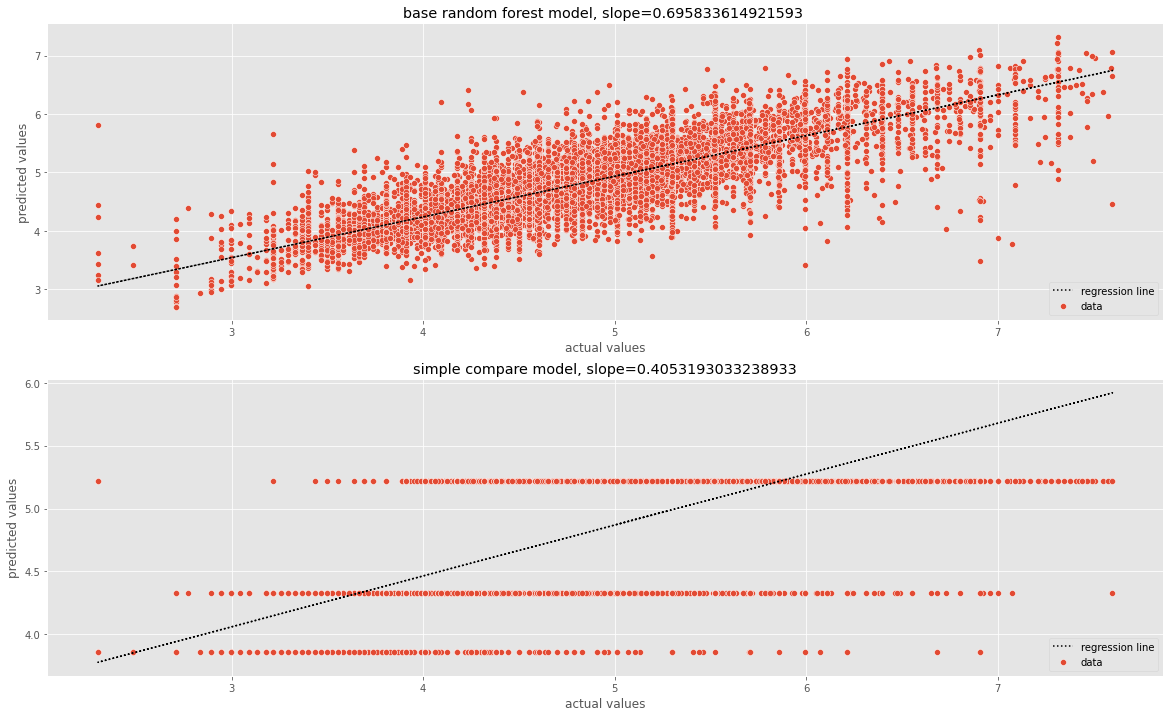

In [ ]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    b = mean(ys) - m*mean(xs)
    return m, b


m_forest,b_forest = best_fit_slope_and_intercept(y_test,y_test_pred)
m_compare,b_compare=best_fit_slope_and_intercept(y_test,y_compare_test_pred)
regression_line_forest=[(m_forest*x)+b_forest for x in y_test]
regression_line_compare=[(m_compare*x)+b_compare for x in y_test]
base_compare=pd.DataFrame(y_test,y_test_pred,y_compare_test_pred)
#plt.style('ggplot2')
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
sns.scatterplot(data=base_compare,x=y_test,y=y_test_pred,label='data')
plt.title(f"base random forest model, slope={m_forest} ")
plt.ylabel("predicted values")
plt.xlabel("actual values")
plt.plot(y_test, regression_line_forest,":k",label='regression line')
plt.legend(loc=4)
plt.subplot(2,1,2)
sns.scatterplot(data=base_compare,x=y_test,y=y_compare_test_pred,label='data')
plt.title(f"simple compare model, slope={m_compare}")
plt.ylabel("predicted values")
plt.xlabel("actual values")
plt.plot(y_test, regression_line_compare,":k",label='regression line')
plt.legend(loc=4)
plt.show()

* our base model predicted test values have a higher correlation with the actual test values - which means that it predicts better

Feature importance 

In [ ]:
from sklearn import preprocessing
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
# Create a list of feature names
feat_labels=list(X.columns)
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=80, random_state=0)
lab_enc = preprocessing.LabelEncoder()
y_label_encoded = lab_enc.fit_transform(y_train)
# Train the classifier
clf.fit(X_train, y_label_encoded)
# show the importance of each feature
importance_list=[]
for feature,importance in zip(feat_labels, clf.feature_importances_):
    importance_list.append(float(importance))

importance_df=pd.concat([pd.Series(feat_labels),pd.Series(importance_list)],axis=1)
#show features importance
importance_df.columns=['features','importance']
plt.figure(figsize=(15,5))
sns.barplot(data=importance_df.sort_values(by='importance',ascending=False),x='features',y='importance')

In [ ]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.017
sfm = SelectFromModel(clf, threshold=0.017)
# Train the selector
sfm.fit(X_train, y_label_encoded)
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

latitude
longitude
number_of_reviews
review_scores_rating
zipcode
neighbourhood_code
host_since_year
review_span
amenities_num
supplies
security
desc_len
name_len
text_len
size
zipcode_population_density
zipcode_median_household_income
zipcode_housing_units


In [ ]:
selected_feat= X_train.columns[(sfm.get_support())]
print("number of important columns:",len(selected_feat))

number of important columns: 18


In [ ]:
print("names of selected features:","\n\n",selected_feat)

names of selected features: 

 Index(['latitude', 'longitude', 'number_of_reviews', 'review_scores_rating',
       'zipcode', 'neighbourhood_code', 'host_since_year', 'review_span',
       'amenities_num', 'supplies', 'security', 'desc_len', 'name_len',
       'text_len', 'size', 'zipcode_population_density',
       'zipcode_median_household_income', 'zipcode_housing_units'],
      dtype='object')


In [ ]:
# Transform the data to create a new dataset containing only the most important features
X_train=X_train[list(selected_feat)]
X_test=X_test[list(selected_feat)]
print(" new train data shape:",X_train.shape,"\n","new test data shape:",X_test.shape)

 new train data shape: (7000, 18) 
 new test data shape: (3000, 18)


apply a random forestmodel on the new datasets

In [ ]:
rf=RandomForestRegressor().fit(X_train,y_train)
y_train_pred=rf.predict(X_train)
print(f'train RMSE is {np.exp(mse(y_train, y_train_pred)**0.5) :.2f}')
y_test_pred=rf.predict(X_test)
print(f'test RMSE is {np.exp(mse(y_test, y_test_pred)**0.5) :.2f}')

train RMSE is 1.18
test RMSE is 1.55


* almost the same as our base model, we didn't pay a lot for removing the columns, thus we gained simplifying the model with more or less the same accuracy
* it seems like we have an overfitting problem, let's try to adjust our hyperparameters to get rid of this problem

Hyper parameters analysis

In [ ]:
# Let’s check how the Random Forest model will behave while growing number of trees. 
# we will display the changes in price, to recieve clearer plots
X_1, y_1 = df_sample.drop(columns=['log_price', 'price']), df_sample.price
X_1_train, X_1_test, y_1_train, y_1_test = split(X_1, y_1, test_size=0.3, random_state=0)
#subset to the important features
X_1_train=X_1_train[list(selected_feat)]
X_1_test=X_1_test[list(selected_feat)]
rf_1=RandomForestRegressor().fit(X_1_train,y_1_train)
trees, train_loss, test_loss = [], [], []

for iter in range(20):
    rf_1.fit(X_1_train, y_1_train)
    y_1_train_predict = rf_1.predict(X_1_train)
    y_1_test_predict  = rf_1.predict(X_1_test)
    mse_train = mse(y_1_train, y_1_train_predict)
    mse_test =  mse(y_1_test, y_1_test_predict)
    print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    trees += [rf_1.n_estimators]
    train_loss += [mse_train]
    test_loss += [mse_test]
    rf_1.n_estimators += 15

plt.figure(figsize=(18,12))  
plt.subplot(2,2,1)
plt.plot(trees, train_loss, color="blue")
plt.title("MSE on Train data")
plt.xlabel("# of trees")
plt.ylabel("MSE")
plt.subplot(2,2,2)
plt.plot(trees, test_loss, color="red")
plt.title("MSE on Test data")
plt.xlabel("# of trees")
plt.ylabel("MSE")

* 100 trees (default value): low MSE on test data , high in train data - so we wont overfit but won't get good accuracy
* we want to find a number of trees that gives accurate results and won't overfit - example for a number of trees that satisfies both conditions: 350

In [ ]:
# Random Forest model behaviour in different max_depth values. 
rf_2=RandomForestRegressor().fit(X_1_train,y_1_train)
depth, train_loss, test_loss = [], [], []
rf_2.max_depth=1
for iter in range(20):
    rf_2.fit(X_1_train, y_1_train)
    y_1_train_predict = rf_2.predict(X_1_train)
    y_1_test_predict  = rf_2.predict(X_1_test)
    mse_train = mse(y_1_train, y_1_train_predict)
    mse_test =  mse(y_1_test, y_1_test_predict)
    print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    depth += [rf_2.max_depth]
    train_loss += [mse_train]
    test_loss += [mse_test]
    rf_2.max_depth += 10

plt.figure(figsize=(18,12))  
plt.subplot(2,2,1)
plt.plot(depth, train_loss, color="blue")
plt.title("MSE on Train data")
plt.xlabel("depth of trees")
plt.ylabel("MSE")
plt.subplot(2,2,2)
plt.plot(depth, test_loss, color="red")
plt.title("MSE on Test data")
plt.xlabel("depth of trees")
plt.ylabel("MSE")

* the deeper the tree - the more accurate the result

Iteration: 0 Train mse: 2148.414286614285 Test mse: 14330.844618533332
Iteration: 1 Train mse: 10653.246814781547 Test mse: 13195.393484788983
Iteration: 2 Train mse: 12815.063483288026 Test mse: 13219.178086089125
Iteration: 3 Train mse: 13956.46139662967 Test mse: 13523.646378179708
Iteration: 4 Train mse: 14730.294041276391 Test mse: 13719.809749216865
Iteration: 5 Train mse: 15238.373305334799 Test mse: 13900.283312886837
Iteration: 6 Train mse: 15719.198756268936 Test mse: 14012.614162115831
Iteration: 7 Train mse: 16087.902764547633 Test mse: 14266.109909910683
Iteration: 8 Train mse: 16261.802611990091 Test mse: 14301.261258893679
Iteration: 9 Train mse: 16436.956713062624 Test mse: 14366.432019902537


Text(0, 0.5, 'MSE')

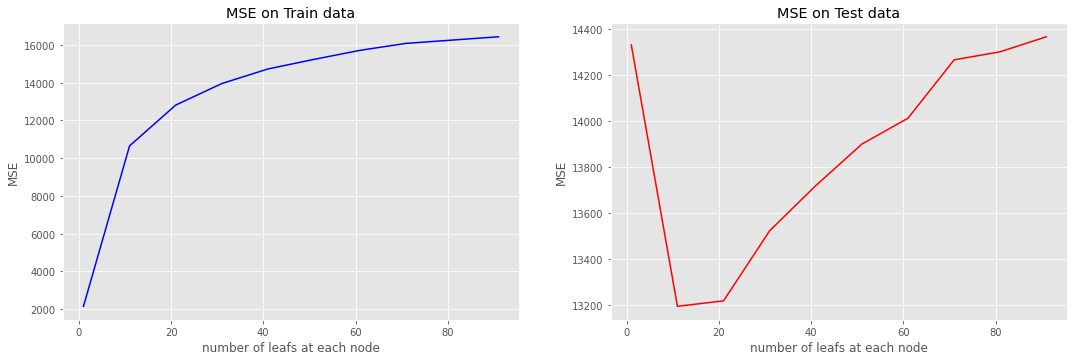

In [ ]:
# Random Forest model behaviour in different min_samples_leaf values. 
rf_3=RandomForestRegressor().fit(X_1_train,y_1_train)
min_samples_leaf, train_loss, test_loss = [], [], []
for iter in range(10):
    rf_3.fit(X_1_train, y_1_train)
    y_1_train_predict = rf_3.predict(X_1_train)
    y_1_test_predict  = rf_3.predict(X_1_test)
    mse_train = mse(y_1_train, y_1_train_predict)
    mse_test =  mse(y_1_test, y_1_test_predict)
    print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    min_samples_leaf += [rf_3.min_samples_leaf]
    train_loss += [mse_train]
    test_loss += [mse_test]
    rf_3.min_samples_leaf += 10

plt.figure(figsize=(18,12))  
plt.subplot(2,2,1)
plt.plot(min_samples_leaf, train_loss, color="blue")
plt.title("MSE on Train data")
plt.xlabel("number of leafs at each node")
plt.ylabel("MSE")
plt.subplot(2,2,2)
plt.plot(min_samples_leaf, test_loss, color="red")
plt.title("MSE on Test data")
plt.xlabel("number of leafs at each node")
plt.ylabel("MSE")

in train dataset, the mse gets bigger constantlystarting at leaf=1
in test dataset, the mse gets bigger  constantly starting at leaf=11
we want to find a point which yields an accurate predictions bu at the same time time doesn't overfit - example : 10

applying the different parameters values on the rf model

In [ ]:
rf=RandomForestRegressor(n_estimators=350,max_depth=15,min_samples_leaf=10,max_features=10).fit(X_train,y_train)
y_train_pred=rf.predict(X_train)
print(f'train RMSE is {np.exp(mse(y_train, y_train_pred)**0.5) :.2f}')
y_test_pred=rf.predict(X_test)
print(f'test RMSE is {np.exp(mse(y_test, y_test_pred)**0.5) :.2f}')

train RMSE is 1.45
test RMSE is 1.56


•	Random Hypermater Grid Search 


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,50,100]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 50, 100], 'bootstrap': [True, False]}


* Use the random grid to search for best hyperparameters


In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,cv=3, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 55.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 114.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

* View the best parameters from fitting the random search:


In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1200}

* Evaluate Random Search

In [ ]:
### To determine if random search yielded a better model, we compare the base model with the best random search model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


base_accuracy = evaluate(rf, X_test, y_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random,X_test, y_test)
print(f'Improvement of {str(random_accuracy - base_accuracy)[0:4]}%')
print(f"new rmse is: {np.exp(mean((np.log(best_random.predict(X_test)/y_test)))**0.5)}")

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
best_random=RandomForestRegressor(bootstrap=False,max_depth=40,max_features='sqrt',min_samples_leaf=10,min_samples_split=5,n_estimators=1200).fit(X_train,y_train)

a=best_random.predict(X_train)
print(f'train RMSE is {np.exp(mse(y_train, a)**0.5) :.2f}')
b=best_random.predict(X_test)
print(f'test RMSE is {np.exp(mse(y_test, b)**0.5) :.2f}')

train RMSE is 1.40
test RMSE is 1.55


#### Highly correlated features

The relationship between two variables is generally considered strong when their r value is larger than 0.7 - so any two features with a correlation larger than 0.7 will result in dropping one of them since they are describing the same phenomenon

In [ ]:
strong_correlations=correlation_df[correlation_df.correlations>0.7].iloc[1:] ### correlation betweeen columns other than log_price(label)
strong_correlations.unstack(0).fillna(0)

* any column that is strongly correlated with a group of columns will be kept in mind as a suspect to be dropped later when we adjust our model's accuracy
* plus we can think of new features based on highly correlated columns

In [ ]:
#Refrigerator is strongly correlated with  Oven,Dishes and silverware, Cooking basics, Microwave Coffee maker
#Hot water related to Bed linens,Extra pillows and blankets
#zipcode related to longitude and latitude
#"translation missing: en.hosting_amenity_50" related to "translation missing: en.hosting_amenity_49"
# Washer related to Dryer
# Stove related to Refrigerator
# House related to Apartment
# beds related to accomodates
#self Check-in related to Lockbox


In [ ]:
correlations=df.corr()
# show the correlation in a dataframe in their absolute value
correlation_df=pd.DataFrame(correlations.stack().drop_duplicates().abs().sort_values(ascending=False)).rename(columns={0:"correlations"})

## Error Analysis

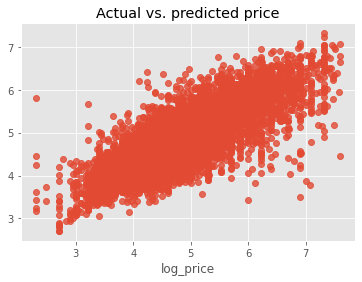

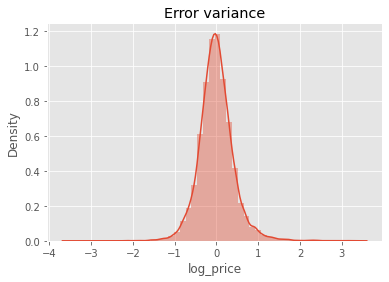

In [ ]:
sns.regplot(x = y_test, y = y_test_pred, fit_reg=False)
plt.title('Actual vs. predicted price')
plt.show()
sns.distplot(y_test - y_test_pred, bins = 50)
plt.title('Error variance')
plt.show()

Looks like the error is balanced. Let's check the error as a function of log_price

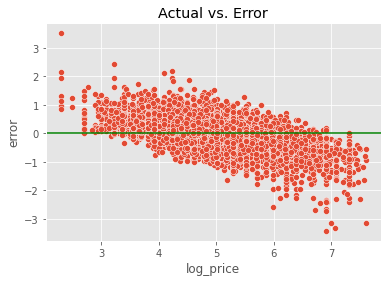

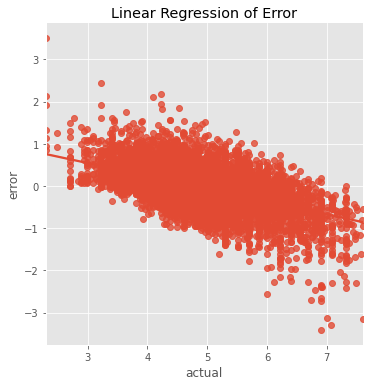

In [ ]:
error = (y_test_pred - y_test).rename('error')
sns.scatterplot(x=y_test, y=error )
plt.axhline(0, c='g')
plt.title('Actual vs. Error')

# pred_test = pd.concat([pd.Series(y_test_pred).rename('predicted'), pd.Series(y_test)], axis=1)
pred_test = pd.DataFrame({'predicted': y_test_pred, 'actual': y_test})
pred_test = pred_test.assign(error = pred_test.predicted - pred_test.actual)
sns.lmplot(x='actual', y='error', data=pred_test)
plt.title('Linear Regression of Error');

The error is more towards over-estimation in low prices, and under-estimate in high prices. Something to look into...<br>
Now, let check the error by key features: 

In [ ]:
base_df = pd.concat([X_test.reset_index(), pd.DataFrame(y_test_pred, columns=['predicted']), pd.DataFrame(y_test.values, columns=['actual'])], axis=1)
base_df['city'] = np.where(base_df.city_NYC == 1, 'NYC', np.where(base_df.city_Chicago == 1, 'Chicago', np.where(base_df.city_DC == 1, 'DC', 
    np.where(base_df.city_LA == 1, 'LA', np.where(base_df.city_SF == 1, 'SF', 'Unknown')))))
base_df['mse'] = base_df.apply(lambda row: (row.actual - row.predicted)**2, axis=1)

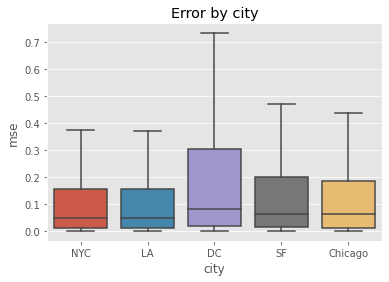

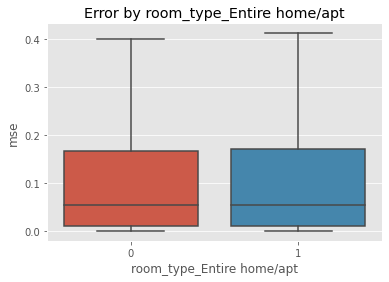

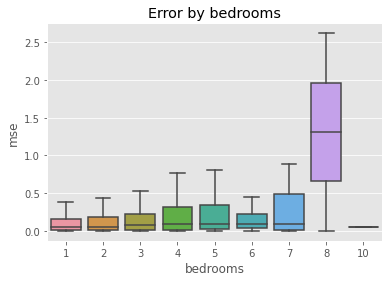

In [ ]:
for col in ['city', 'room_type_Entire home/apt', 'bedrooms']:
    sns.boxplot(x=col, y='mse', data=base_df, showfliers=False)
    plt.title('Error by ' + col)
    plt.show()

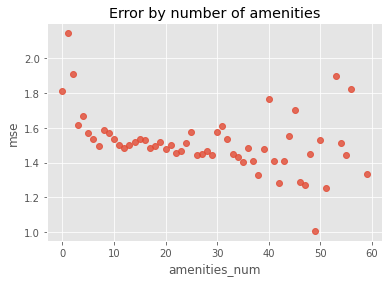

In [ ]:
error_df = np.exp(base_df.groupby('amenities_num').mse.mean()**0.5)
sns.regplot(x=error_df.index, y=error_df, fit_reg=False)
plt.title('Error by number of amenities');

We can see that areas with fewer data, like city=DC, or 8 bedrooms listings, have higher errors.<br>
Let's check some sample of the really high errors

In [ ]:
pd.cut(base_df.mse, 10).value_counts().sort_index()

(-0.0123, 1.23]     14725
(1.23, 2.46]          199
(2.46, 3.69]           39
(3.69, 4.92]           15
(4.92, 6.15]           13
(6.15, 7.381]           3
(7.381, 8.611]          1
(8.611, 9.841]          1
(9.841, 11.071]         2
(11.071, 12.301]        2
Name: mse, dtype: int64

In [ ]:
base_df[base_df.mse > 2.5]

,index,accommodates,bathrooms,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,neighbourhood_code,host_since_year,first_review_year,last_review_year,review_span,amenities_num,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bathtub with shower chair,Beach essentials,Beachfront,Bed linens,Breakfast,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,...,laundry,basic_laundry,comm,basic_comm,sea,basic_sea,extra,basic_extra,house,basic_house,supplies,kids,security,basic_security,pets,entry,desc_len,name_len,text_len,text_location,text_location_transportation,text_location_food_and_drinks,text_location_attractions,text_location_distance,text_design_and_traits,text_general,size,property_Apartment,property_House,property_Condominium,property_Townhouse,property_Loft,zipcode_population_density,zipcode_median_household_income,zipcode_housing_units,bath_ratio,predicted,actual,city,mse
80,44414,2,1.0,0,1.0,0.0,100.0,0,40.731273,-73.985941,0,0.0,10003,1,1,157,2013.0,0.0,0.0,0.0,10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,4,1,0,0,1,1,0,0,0,0,1,1,0,0,166,31,198,0,0,0,0,0,1,1,2.25,1,0,0,0,0,97188.0,92540.0,31078.0,1.000000,5.178512,7.221105,NYC,4.172185
202,17627,2,1.0,1,1.0,1.0,100.0,0,40.719191,-73.989919,53,84.0,10002,1,1,305,2015.0,2015.0,2016.0,387.0,15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,0,0,5,1,0,0,0,0,0,0,4,1,3,0,0,0,877,25,903,1,1,1,0,1,1,1,2.25,1,0,0,0,0,92573.0,33218.0,34541.0,1.000000,4.435620,6.396930,NYC,3.846737
229,39443,2,1.0,0,1.0,0.0,100.0,1,34.097537,-118.350897,8,83.0,90046,1,1,244,2014.0,2015.0,2015.0,71.0,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3,1,0,0,1,1,0,0,0,0,1,0,1,0,934,35,970,1,0,1,1,1,1,1,2.25,1,0,0,0,0,8405.0,52641.0,30688.0,1.000000,4.219799,6.380123,LA,4.666999
267,4333,2,1.0,0,1.0,1.0,100.0,0,38.931554,-77.030828,0,0.0,20010,1,1,-1,2014.0,0.0,0.0,0.0,16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,2,1,3,1,0,0,1,1,0,0,3,1,3,0,0,0,1000,50,1051,1,0,1,0,1,1,1,2.25,1,0,0,0,0,27801.0,65287.0,13861.0,1.000000,4.420716,6.214608,DC,3.218048
317,68899,2,2.0,1,1.0,0.0,100.0,0,33.902953,-118.260560,0,0.0,90015,1,1,-1,2014.0,0.0,0.0,0.0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,3,1,0,0,0,0,0,0,3,1,3,0,1,0,1000,35,1036,0,0,0,0,0,1,1,2.25,0,0,0,0,0,11100.0,27393.0,8245.0,2.000000,3.774042,7.073270,LA,10.884906
321,21406,6,1.0,1,1.0,1.0,88.0,0,38.891288,-76.982710,0,0.0,20002,2,2,270,2015.0,0.0,0.0,0.0,16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,2,1,4,1,0,0,0,0,0,0,5,1,1,0,0,1,1000,25,1026,1,1,1,1,0,1,1,5.50,1,0,0,0,0,9961.0,65000.0,26166.0,0.500000,6.174746,4.234107,DC,3.766081
493,9649,10,4.5,1,1.0,1.0,100.0,0,34.052578,-118.140315,52,93.0,91754,4,4,343,2012.0,2012.0,2014.0,751.0,17,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,2,1,4,1,0,0,2,1,0,0,2,1,1,0,0,0,1000,33,1034,1,0,1,1,1,1,1,10.00,0,1,0,0,0,7224.0,57630.0,11718.0,1.125000,5.597980,7.313220,LA,2.942051
677,5060,4,2.0,0,1.0,1.0,100.0,0,40.720862,-73.988571,0,0.0,10002,1,2,305,2013.0,0.0,0.0,0.0,14,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,2,1,3,1,0,0,0,0,0,0,2,1,3,0,0,0,302,26,329,1,0,1,0,0,1,1,3.50,0,0,0,0,0,92573.0,33218.0,34541.0,2.000000,4.496773,6.214608,NYC,2.950958
937,43559,10,2.0,1,1.0,0.0,70.0,0,40.776819,-73.903754,1,100.0,11105,8,8,134,2015.0,2017.0,2017.0,0.0,22,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,...,2,1,3,1,0,0,0,0,0,0,7,0,4,0,0,0,1000,49,1050,1,1,1,1,1,1,1,15.00,0,0,0,0,1,22481.0,57525.0,17416.0,0.250000,5.019967,3.401197,NYC,2.620415
968,19079,2,1.0,0,1.0,0.0,100.0,1,38.909172,-77.082708,0,0.0,20007,1,1,195,2015.0,0.0,0.0,0.0,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,0,1,0,2,0,0,0,319,34,354,1,0,0,1,1,1,1,2.25,0,1,0,0,0,8935.0,107511.0,13849.0,1.000000,4.610119,6.354370,DC,3.042410


Interesingly, almost all the above have text_design_and_traits. Worth checking if these are special, more specific properties which are harder to predict<br><br>
Megring back to the original dataframe, we can see that most of these listings have extreme values - either luxurious ones with extermely high prices per night, or very low. the one for $10 per night is probably bad data

In [ ]:
orig_df['price'] = np.exp(orig_df.log_price)
base_df[base_df.mse > 2.5][['longitude', 'latitude']].merge(orig_df, on=['longitude', 'latitude'])[['city', 'name', 'description', 'price']]

,city,name,description,price
0,NYC,1000 square feet 1 bedroom apt!,"Apt available in a new luxury doorman, gym building for Super bowl weekend Apt is about 950 sqft with lounge, bedroom and 1 full bathroom. Book it while it lasts!!!!",1368.0
1,NYC,Large Furnished Apartment,"Sunny, quiet and comfortable one bedroom available in a great neighborhood on the LES in NYC. Just blocks away from fantastic restaurants and all subway lines in a 2 block radius. Bedroom: Large double xl bed, fresh linens, closet, desk and chair, dresser. Private room on opposite sides of apartment Located on quiet block in Lower East Side. Two blocks away are amazing coffee shops, restauran...",600.0
2,LA,The perfect West Hollywood location,"I have a bedroom in my two bed two bath apartment available for rent. I am in a prime west Hollywood location. Blocks away from the walk of fame, a 10 minute walk from Runyon Canyon, and centered to all the Hollywood clubs. The bedroom is very spacious, with a private full bathroom. The two rooms in my apartment are on opposite ends, so you will have full privacy (I have a female roommate stay...",590.0
3,DC,LARGE private bedroom and bath for DC Inauguration,"Renting out a lovely and LARGE private bedroom and full bathroom for the Inauguration Weekend. Bedroom is very spacious with hard wood floors, two large windows, high ceilings, a desk area and extra seating. You will be within walking distance to great restaurants and bars like Meridian Pint, The Coupe, and RedRocks Firebrick Pizzeria. You’ll also be a five-minute walk away from the Columbia ...",500.0
4,LA,Party Warehouse Spacious Industrial,"Wake-Up to our Event Warehouse & plan your next event with us while you Stay, Work & Play. We have 4 creative workspaces available for all your creativity needs daily & weekly. Event Celebrations, Photo & Film Shoots, also music & even birthday dinner parties. This Warehouse can entertain 75 of your special guest. We offer an open dance floor for filming & photography or just for a private par...",1180.0
5,DC,Affordable Cap. Hill Apt.,"This is a Lovely Cozy Affordable 2 Bedroom Apartment Home.You’ll love my place because of the comfy beds and the coziness. My place is good for couples, solo adventurers, and business (URL HIDDEN) is a designated parking spot and there is a daily fee for parking. PARTIES and LOUD Noises are strictly prohibited and EVICTION without refund if this very important rule is violated. This is a smal...",69.0
6,LA,Amazing hillside 4 bdrm 4k sq ft,"Hillside 4000 sqare feet home with 4 bedrooms and lovely views. Very central to all of the LA attractions. Close to supermarkets, and restaurants. Create amazing memories with your family and friends at this million dollar hillside home located in Monterey Park (San Gabriel Valley) with 5 floors, 5 bathrooms, 4 bedrooms, 2 large generous decks, and an elevator! A 15min drive to downtown and 2...",1500.0
7,NYC,Lower Eastside Modern Loft,Modern full floor loft with private elevator and two balconies on both sides of apartment. Floor to ceiling windows with modern furniture and lots of open space. Everything is brand new and clean. Right on Ludlow street overlooking best restaurants and lively neighborhood in New York city. No parties.,500.0
8,NYC,Private Bedroom in Spacious Luxury Loft (Astoria),"Sitting in the heart of cultural mecca Astoria, Queens, mere minutes from the bustling streets of Manhattan, is where this 4,000 square foot loft can be found. Located in a safe, clean neighborhood across the street from a school, and 1 block away from the historical Steinway Street shopping district. Restaurants, shops, and store flood the tree-lined streets of this area. This spacious...",30.0
9,DC,Master Bedroom w/ Private bathroom,"Located in the quiet and exclusive neighborhood of Foxhall, Washington DC. A master bedroom featuring a queen-size bed and walk-in shower. A parking spot for smaller cars in rear of house. I look forward to meeting you on arrival. Shou

Lastly, let's try to predict if a row belongs to the train, or test as dataset, in order to validate our train/test split

In [ ]:
unified = pd.concat([X_train.assign(source=0), X_test.assign(source=1)]).sample(5000)
X, y = unified.drop(columns='source'), unified.source
X_train, X_test, y_train, y_test = split(X, y, test_size=0.5, random_state=0)
rf = RandomForestClassifier().fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
print(abs(y_test_pred - y_test).sum(), 'errors out of', len(y_test), 'rows')

1262 errors out of 2500 rows


That's about 50% classification error, which means the model can't predict train vs. test rows - good !

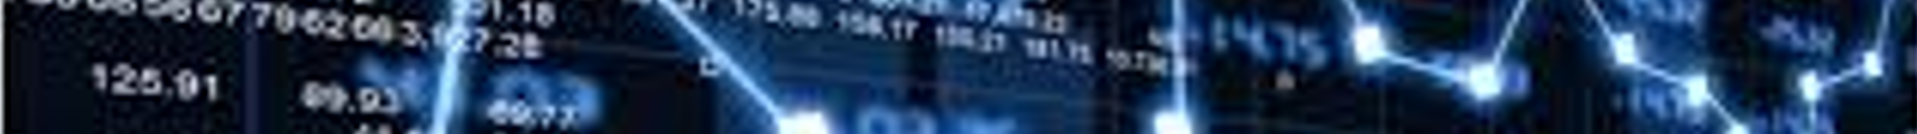